In [359]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate
from matplotlib import cm
from scipy import fft
from matplotlib.animation import FuncAnimation, PillowWriter 
import pandas as pd
from sklearn.linear_model import LinearRegression
import time
from scipy.interpolate import RegularGridInterpolator

In [360]:
# define parameters and functions:
alpha = .5
epsilon = .1 #.1 gives things that look like solitons
L_= 2
L = np.pi*L_
V = -1
D_ = 0.6 #very intereting with D=0.5 (which is the same as Ma=1/4) and D = 0.6

In [398]:
N = 512
Nx = N
n = np.arange(N);
n[int(N/2)+1:] -= N
def RHS_static_cylinder(t,eta):
    eta_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(eta))
    eta_zzz = fft.ifft((n*2*np.pi/L*1j)**3*fft.fft(eta))
    deta_dt = -1/3*fft.ifft(2*n*np.pi/L*1j*fft.fft(eta**3*(1 + D_*eta_z + epsilon**2*eta_zzz))).real
    return deta_dt

def RHS_moving_cylinder(t,eta):
    N = len(eta)
    n = np.arange(N);
    n[int(N/2)+1:] -= N
    eta_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(eta))
    eta_zzz = fft.ifft((n*2*np.pi/L*1j)**3*fft.fft(eta))
    deta_dt = -1/3*fft.ifft(2*n*np.pi/L*1j*fft.fft(eta**3*(1 + D_*eta_z + epsilon**2*eta_zzz))).real
    deta_dt += - V*alpha/2*fft.ifft(2*n*np.pi/L*1j*fft.fft((1+eta/alpha)**2)).real
    return deta_dt

7


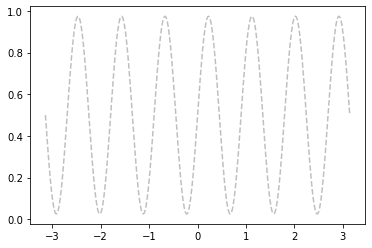

3.141592653589793
Starting solve
(512, 600)  solved static
Time to solve 161.09291911125183 s


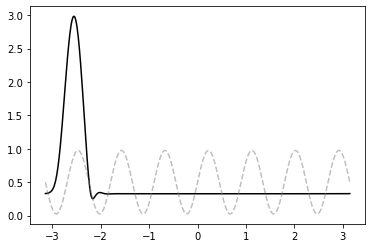

In [409]:
K = 1
T = 100
k = int(1/np.sqrt(2)/epsilon)
print(k)
z = np.linspace(-L/2, L/2, Nx)
t = np.linspace(0,T, 600)
t_span = (0,T)
u0 = (1 + np.sin(z*k)*0.95)*(1-alpha)*K
plt.plot(z,u0, '--', alpha = 0.5, color='grey', label='IC');plt.show()
print(np.trapz(u0, z))

print('Starting solve')

#result_moving = scipy.integrate.solve_ivp(RHS_moving_cylinder, t_span, u0, 'BDF', atol = 1e-2, t_eval =t)
#u_moving = result_moving.y
#print(np.shape(u_moving), ' solved moving')
st = time.time()
result_static = scipy.integrate.solve_ivp(RHS_static_cylinder, t_span, u0, 'BDF', atol = 1e-3, t_eval = t)
u_static = result_static.y
print(np.shape(u_static), ' solved static')
et = time.time()
print(f'Time to solve {et-st} s')
Z,T = np.meshgrid(z,t)
plt.plot(z, u_static[:,-1], color='black', label='Travelling wave')
plt.plot(z,u0, '--', alpha = 0.5, color='grey', label='IC');plt.show()

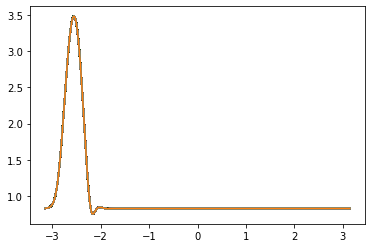

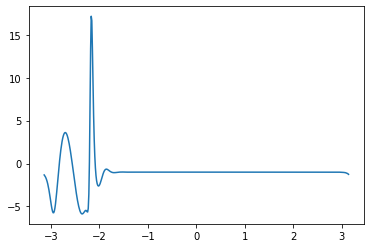

In [410]:
## Now, first find the pressure, p = p(z) only
S = u_static[:, -1]+alpha
r = np.linspace(alpha, max(S)+0.03, len(z))
R,Z = np.meshgrid(r,z)

#get the fourier series of S
plt.plot(Z, S)
plt.show()
Ma = 1/2*(1-D_)
p = 1/S - epsilon**2*fft.ifft((2*n*np.pi/L*1j)**2*fft.fft(S)) - Ma/S**2
p_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(p)).real
S_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(S)).real
p_zz = fft.ifft(2*n*np.pi/L*1j*fft.fft(p_z)).real
#plt.plot(z,p_z)
plt.plot(z,p_z-1)

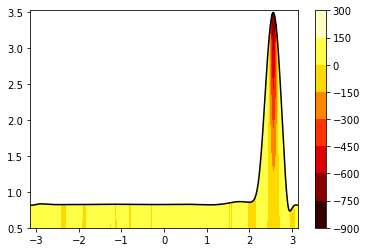

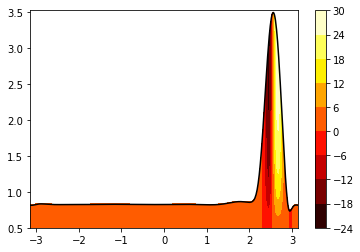

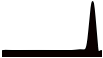

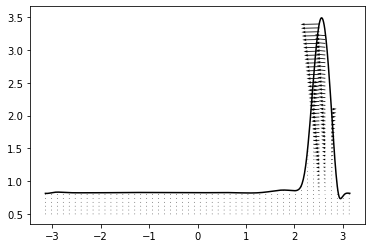

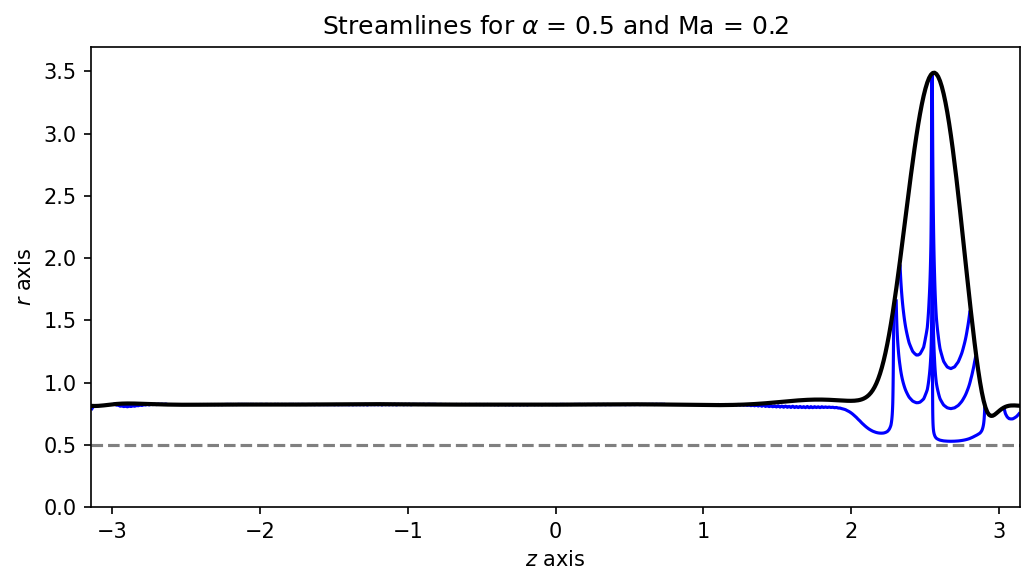

In [408]:
S = u_static[:, -1]+alpha
r = np.linspace(alpha, max(S)+0.03, len(z))
R,Z = np.meshgrid(r,z)


Ma = 1/2*(1-D_)
p = 1/S - epsilon**2*fft.ifft((2*n*np.pi/L*1j)**2*fft.fft(S)) - Ma/S**2
p_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(p)).real


w_unmasked = np.zeros((len(r), len(z)))
u_unmasked = np.zeros((len(r), len(z)))
psi = np.zeros((len(r), len(z)))
mask = np.zeros((len(r), len(z)))
for j,r_ in enumerate(r):
    #print(r_)
    w_unmasked[j,:] = -1/4*(p_z-1)*(2*S**2*np.log(r_/alpha)+alpha**2-r_**2)
    u_unmasked[j,:] = 1/16/r_*(4*(alpha**2-r_**2+2*r_**2*np.log(r_/alpha))*S*(p_z-1)*S_z-(r_**2-alpha**2)**2*p_zz)
    u_unmasked[j,:] += 1/16/r_*(alpha**2-r_**2+2*r_**2*np.log(r_/alpha)*2*p_zz*S**2)
    psi[j,:] = 1/16*(r_**2-2*r_**2*alpha**2+2*(alpha**2-r_**2+2*r_**2*np.log(r_/alpha))*S**2*(p_z-1)-p_z*(r_**2-alpha**2)**2)
for j, z_ in enumerate(z):
    r_star = np.argmin(abs(S[j]+0.01-r))
    #print(r_star)
    for l in range(r_star):
        mask[l,j] = 1
masked_psi = np.where(mask, psi, np.nan)
masked_u = np.where(mask, u_unmasked, np.nan)
masked_w = np.where(mask, w_unmasked, np.nan)
plt.contourf(Z,R,masked_u.T, cmap='hot');plt.colorbar()
plt.plot(z, S, color ='black')
plt.show()
plt.contourf(Z,R,masked_w.T, cmap='hot');plt.colorbar()
plt.plot(z, S, color ='black')
plt.show()
fig, ax = plt.subplots(dpi=15, figsize = (7,4))
plt.pcolormesh(Z,R,(-mask).T, cmap ='hot', shading ='auto')
plt.plot(z, S, color ='black', linewidth =5)
ax.axis('off')
plt.tight_layout()
plt.savefig('streamlines_figures/M4R_logo.pdf')
plt.show()
## flow field
stride = 10
masked_u_s = masked_u[::stride, ::stride]
masked_w_s = masked_w[::stride, ::stride]
Z_s = Z[::stride, ::stride]
R_s = R[::stride, ::stride]
plt.plot(z, S, color ='black')
plt.quiver(Z_s, R_s, masked_u_s.T, masked_w_s.T, scale =10000)
plt.show()
#streamlines
plt.show()
fig, ax = plt.subplots(dpi=150, figsize = (7,4))
plt.contour(Z,R, masked_psi.T, levels = np.array([-5,-1, 0,1,5]), colors='blue', linestyles='solid'); 
#plt.colorbar()
plt.plot(z, S, color ='black', linewidth =2);plt.plot(z, np.ones_like(z)*alpha, '--', color='grey')
plt.ylim([0, 3.7])
plt.title(fr'Streamlines for $\alpha$ = {alpha} and Ma = {Ma}')
plt.xlabel(r'$z$ axis')
plt.ylabel(r'$r$ axis')
plt.tight_layout()
plt.savefig('streamlines_figures/streamlines.jpg')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (512,) and (256, 256)

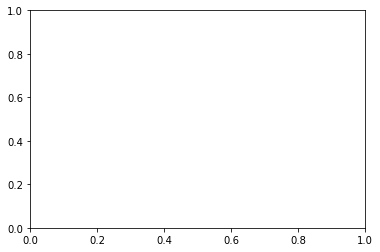

In [407]:
plt.plot(r, w)
plt.show()

In [ ]:
# Assuming you have numpy arrays for r, z, and psi
mask = R < S
masked_psi = np.where(mask, psi, np.nan)
plt.plot(z, S)
plt.contour(Z, R, masked_psi.T)
plt.xlabel('r')
plt.ylabel('z')
plt.title('Contours of psi(r, z) for r < S(z)')
plt.show()
plt.pcolormesh(Z,R,mask)
plt.plot(z, S)


In [ ]:
# define the vector fields 
def u_field(x):
    interp_u = RegularGridInterpolator((r, z), uv,bounds_error=False, fill_value=None)
    return interp_u(x)
def w_field(x):
    interp_w = RegularGridInterpolator((r, z), w,bounds_error=False, fill_value=None)
    return interp_w(x)
# integrate trajectories 
def f(x,t):
    return np.array([u_field(x), w_field(x)])[:,0]
y0 = np.array([alpha+0.1, L/2-0.5])
print(f(y0,t))
t = np.linspace(0, .1,100)
sol = scipy.integrate.odeint(f, y0, t, full_output=1)

# iterate boundary conditions
plt.figure(dpi = 100)
plt.plot(z, S, color='grey')
plt.plot(z, np.ones(len(z))*alpha, '-.',color='grey')
z_list = [-L/2, L/4,0, -L/4]
for j,r_ in enumerate(np.linspace(alpha+0.1, 0.75, 3)):
    for z_ in np.array(z_list):
        t = np.linspace(0, 20,100)
        y0 = np.array([r_, z_])
        sol = scipy.integrate.odeint(f, y0, t)
        plt.plot(sol[:,1], sol[:,0], color ='black')
    print(round(j/len(r)*100,2))

In [ ]:
#travelling frame
# first find c
profile = u_static[:, 551]
eta_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(profile))
eta_zzz = fft.ifft((n*2*np.pi/L*1j)**3*fft.fft(profile))
deta_dt = -1/3*fft.ifft(2*n*np.pi/L*1j*fft.fft(profile**3*(1 + D_*eta_z + epsilon**2*eta_zzz))).real
plt.plot(z,deta_dt)
plt.plot(z,eta_z.real)
plt.show()
c = (z[np.argmax(u_static[:, -1], axis=0)]-z[np.argmax(u_static[:, 573], axis=0)])/(t[-1]-t[573])
c
plt.plot(z,deta_dt + c*eta_z.real)

In [ ]:
S = u_static[:, 551]+alpha
#S = u0+alpha
r = np.linspace(alpha, max(S)+0.01, len(z))
R,Z = np.meshgrid(r,z)


Ma = 1/2*(1-D_)
p = 1/S - epsilon**2*fft.ifft((2*n*np.pi/L*1j)**2*fft.fft(S)) - Ma/S**2
p_z = fft.ifft(2*n*np.pi/L*1j*fft.fft(p)).real
p_zz = fft.ifft(2*n*np.pi/L*1j*fft.fft(p_z)).real

w_unmasked = np.zeros((len(r), len(z)))
u_unmasked = np.zeros((len(r), len(z)))
psi = np.zeros((len(r), len(z)))
mask = np.zeros((len(r), len(z)))
for j,r_ in enumerate(r):
    #print(r_)
    w_unmasked[j,:] = -1/4*(p_z-1)*(2*S**2*np.log(r_/alpha) + alpha**2 - r_**2)-c
    u_unmasked[j,:] = 1/16/r_*(4*(alpha**2-r_**2+2*r_**2*np.log(r_/alpha))*S*(p_z-1)*S_z-(r_**2-alpha**2)**2*p_zz)
    u_unmasked[j,:] += 1/16/r_*(alpha**2-r_**2+2*r_**2*np.log(r_/alpha)*2*p_zz*S**2)
    psi[j,:] = 1/16*(r_**2-2*r_**2*alpha**2+2*(alpha**2-r_**2+2*r_**2*np.log(r_/alpha))*S**2*(p_z-1)-p_z*(r_**2-alpha**2)**2)+c*r**2/2
for j, z_ in enumerate(z):
    r_star = np.argmin(abs(S[j]+0.01-r))
    #print(r_star)
    for l in range(r_star):
        mask[l,j] = 1
masked_psi = np.where(mask, psi, np.nan)
masked_u = np.where(mask, u_unmasked, np.nan)
masked_w = np.where(mask, w_unmasked, np.nan)
plt.contourf(Z,R,masked_u.T, cmap='hot');plt.colorbar()
plt.plot(z, S, color ='black')
plt.show()
plt.contourf(Z,R,masked_w.T, cmap='hot');plt.colorbar()
plt.plot(z, S, color ='black')
plt.show()
fig, ax = plt.subplots(dpi=15, figsize = (7,4))
plt.pcolormesh(Z,R,(-mask).T, cmap ='hot', shading ='auto')
plt.plot(z, S, color ='black', linewidth =5)
ax.axis('off')
plt.tight_layout()
plt.savefig('streamlines_figures/M4R_logo.pdf')
plt.show()
## flow field
stride = 10
masked_u_s = masked_u[::stride, ::stride]
masked_w_s = masked_w[::stride, ::stride]
Z_s = Z[::stride, ::stride]
R_s = R[::stride, ::stride]
plt.plot(z, S, color ='black')
plt.quiver(Z_s, R_s, masked_u_s.T, masked_w_s.T, scale =10000)
plt.show()
#streamlines
plt.show()
fig, ax = plt.subplots(dpi=150, figsize = (7,4))
plt.contour(Z,R, masked_psi.T, levels = np.array([-50,-1, -0.1,0,0.1,1,50]), colors='blue', linestyles='solid'); 
#plt.colorbar()
plt.plot(z, S, color ='black', linewidth =2);plt.plot(z, np.ones_like(z)*alpha, '--', color='grey')
plt.ylim([0, 3.7])
plt.title(fr'Streamlines for $\alpha$ = {alpha} and Ma = {Ma}')
plt.xlabel(r'$z$ axis')
plt.ylabel(r'$r$ axis')
plt.tight_layout()
plt.savefig('streamlines_figures/streamlines.jpg')
plt.show()